In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2024-03-27 15:37:13.907680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 15:37:13.948518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-27 15:37:13.949376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 15:37:14.820892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load data from CSV file
data = pd.read_csv("all_combined.csv")

In [4]:
X = data['content'].tolist()
data['label'] = data['score'].apply(lambda x: 0 if x < 3 else 1)
y = data['label'].tolist()

In [5]:
# Preprocessing function
def preprocess_text(text):
    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [6]:
# Preprocess all reviews
X_preprocessed = [preprocess_text(review) for review in X]

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_preprocessed)
X_tokenized = tokenizer.texts_to_sequences(X_preprocessed)

In [8]:
# Pad sequences to ensure uniform length
max_len = max(len(x) for x in X_tokenized)
X_padded = pad_sequences(X_tokenized, maxlen=max_len)

In [9]:
X_padded = np.array(X_padded)
y = np.array(y)

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [32]:
# Define the model architecture
model = Sequential()
model.add(Embedding(5000, 256, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 117, 256)          1280000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 117, 256)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1805569 (6.89 MB)
Trainable params: 1805569 (6.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2)

Epoch 1/10
15/15 - 11s - loss: 0.6589 - accuracy: 0.6136 - val_loss: 0.5982 - val_accuracy: 0.7029 - 11s/epoch - 706ms/step
Epoch 2/10
15/15 - 7s - loss: 0.5610 - accuracy: 0.6953 - val_loss: 0.5114 - val_accuracy: 0.7657 - 7s/epoch - 457ms/step
Epoch 3/10
15/15 - 7s - loss: 0.4082 - accuracy: 0.8230 - val_loss: 0.4996 - val_accuracy: 0.7448 - 7s/epoch - 436ms/step
Epoch 4/10
15/15 - 6s - loss: 0.3013 - accuracy: 0.8942 - val_loss: 0.4597 - val_accuracy: 0.7741 - 6s/epoch - 431ms/step
Epoch 5/10
15/15 - 7s - loss: 0.2120 - accuracy: 0.9309 - val_loss: 0.4145 - val_accuracy: 0.8745 - 7s/epoch - 437ms/step
Epoch 6/10
15/15 - 7s - loss: 0.1435 - accuracy: 0.9560 - val_loss: 0.4645 - val_accuracy: 0.8201 - 7s/epoch - 434ms/step
Epoch 7/10
15/15 - 7s - loss: 0.1381 - accuracy: 0.9581 - val_loss: 0.5051 - val_accuracy: 0.8326 - 7s/epoch - 441ms/step
Epoch 8/10
15/15 - 7s - loss: 0.0978 - accuracy: 0.9696 - val_loss: 0.4615 - val_accuracy: 0.8494 - 7s/epoch - 445ms/step
Epoch 9/10
15/15 - 7s 

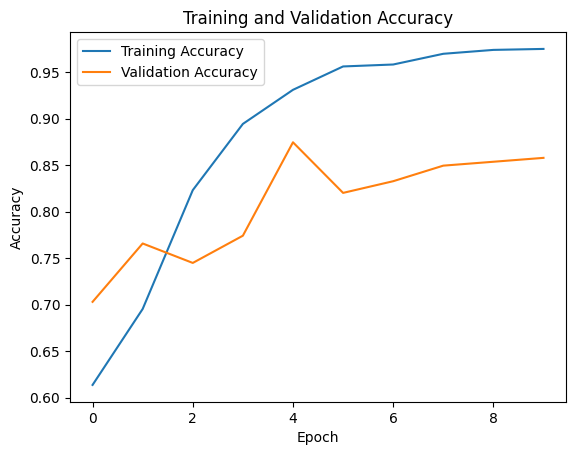

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

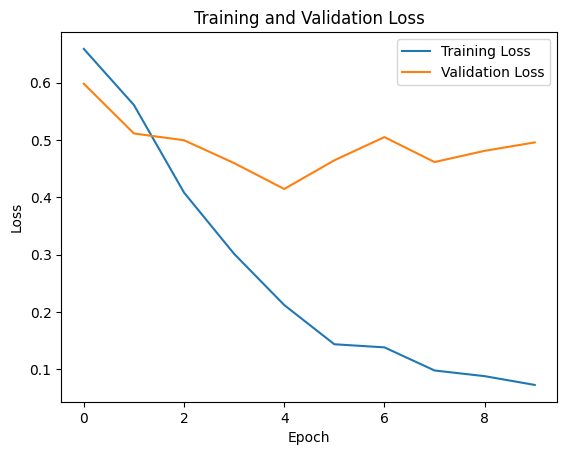

In [14]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
import pickle

# save the model
pickle.dump(model, open('lstm.sav', 'wb'))

In [16]:
# load the model 
load_model = pickle.load(open('lstm.sav', 'rb')) 

In [31]:
input_string = input("enter a string: ")

# preprocessing
preprocessed_string = preprocess_text(input_string)
tokenized_input = tokenizer.texts_to_sequences([preprocessed_string])
input_padded = pad_sequences(tokenized_input, maxlen=max_len)

#prediction
load_model.predict(input_padded)

1/1 [==============================] - 0s 57ms/step


array([[0.65942156]], dtype=float32)